In [1]:
from simulation_utils_extended import * 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf
import gpboost as gpb
import pystan
import arviz as az 

## We now explore in more detail the properties of models which have a Gaussian Process for their random effects part

In particular, we will be focusing on the sparse data regime, where the underlying data-generating process is coming from a shared GP with a non-linear mean function. Also, in this setting, based on our simulation results, the GPBoost model with a shared GP clearly outperforms all other models in both the interpolation and the extrapolation test sets prediction. Hence, we will be focusing on this model for the analysis.

For now we explore the parameter setting with $\rho = 5000, \sigma^2=1$. 

In [2]:
# Generate data
n, m = 500, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
n_datasets = 20 
n_valid = 5

########################
rho , sigma_2 = 5000 , 1
########################

datasets, validation_datasets = generate_datasets(n, m, p, n_datasets, n_valid, func='make_friedman3', random_state=60, shared_gp=True, rho=rho, sigma2_2=sigma_2, no_rand_intercept=True)

# Create groups
groups = np.arange(n)
for i in range(m):
    groups[i*p:(i+1)*p] = i

# Create times for validation datasets
times = np.tile(np.arange(p)*10+10, m)

X_train = datasets['X_train'][0]
F_train = datasets['F_train'][0]
y_train = datasets['y_train'][0]
X_test_int = datasets['X_test2'][0]
X_test_ext = datasets['X_test1'][0]
y_test_int = datasets['y_test2'][0]
y_test_ext = datasets['y_test1'][0]
F_test_int = datasets['F_test2'][0]
F_test_ext = datasets['F_test1'][0]
full_data = datasets['data'][0]
full_data.head()

,group,times,feature_1,feature_2,feature_3,feature_4,y
0,0,18,30.087333,431.063660,0.323183,7.657496,2.969967
1,0,38,56.697080,776.262596,0.379415,1.105815,3.780973
2,0,120,17.036560,327.242594,0.692401,9.744416,6.306860
3,0,224,33.739690,1746.973065,0.131540,6.003298,6.990736
4,0,272,28.662051,486.017341,0.502086,7.360625,4.871280


In [3]:
# Generate data
n, m = 500, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
n_datasets = 1 
n_valid = 1
datasets, validation_datasets = generate_datasets(n, m, p, n_datasets, n_valid, func='make_friedman3', random_state=60, shared_gp=True, rho=rho, sigma2_2=sigma_2, no_rand_intercept=True)

# Create groups
groups = np.arange(n)
for i in range(m):
    groups[i*p:(i+1)*p] = i

# Create times for validation datasets
times = np.tile(np.arange(p)*10+10, m)

i = 0
X_train = datasets['X_train'][i]
F_train = datasets['F_train'][i]
y_train = datasets['y_train'][i]
X_test_int = datasets['X_test2'][i]
X_test_ext = datasets['X_test1'][i]
y_test_int = datasets['y_test2'][i]
y_test_ext = datasets['y_test1'][i]
F_test_int = datasets['F_test2'][i]
F_test_ext = datasets['F_test1'][i]
full_data = datasets['data'][i]
_ , _ , _ , F, rand_effects = generate_data(n, m, p, func='make_friedman3', shared_gp=True, random_state=60, rho=rho, sigma2_2=sigma_2, return_rand_effects=True) 
full_data.head()

,group,times,feature_1,feature_2,feature_3,feature_4,y
0,0,18,30.087333,431.063660,0.323183,7.657496,2.969967
1,0,38,56.697080,776.262596,0.379415,1.105815,3.780973
2,0,120,17.036560,327.242594,0.692401,9.744416,6.306860
3,0,224,33.739690,1746.973065,0.131540,6.003298,6.990736
4,0,272,28.662051,486.017341,0.502086,7.360625,4.871280


## Let's see the random effects prediction of the GPBoost model with a single shared Gaussian Process across all groups.

Covariance parameters: 
        Error_term     group    GP_var    GP_range
Param.    0.682477  0.099977  0.852799  513.384331


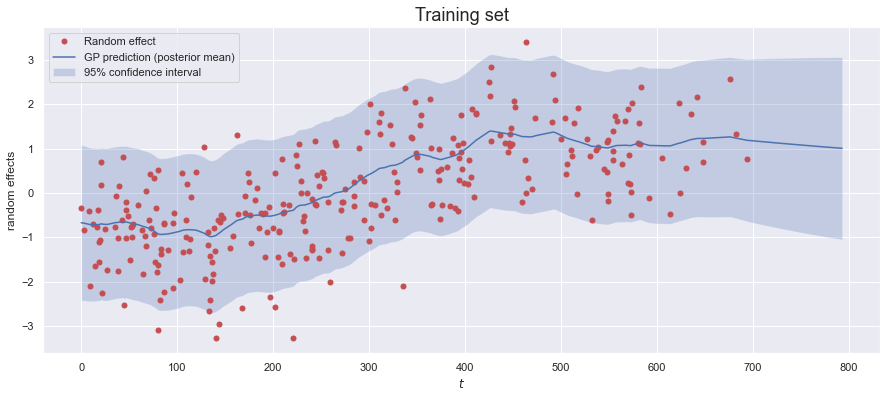

In [19]:
gp_model = gpb.GPModel(gp_coords=X_train['times'], group_data=X_train['group'], cov_function="exponential")
data_train = gpb.Dataset(X_train, y_train)
params = { 'objective': 'regression_l2', 'learning_rate': 0.1,
            'max_depth': 3, 'min_data_in_leaf': 1, 
            'num_leaves': 2**10, 'verbose': 0 }
# Training
bst = gpb.train(params=params, train_set=data_train,
                gp_model=gp_model, num_boost_round=41)
gp_model.summary() # Estimated covariance parameters


# Make predictions: latent variables and response variable
pred = bst.predict(data=X_train, gp_coords_pred=X_train['times'],  group_data_pred=X_train['group'],
                   predict_var=True, pred_latent=True)

# Make predictions using the fitted GP on the on the whole (0, 800) time interval
points = np.arange(X_train['times'].max() + 100, step=1)

predictions_points = gp_model.predict(gp_coords_pred=points, group_data_pred=np.zeros_like(points), predict_var=True)
sigma = np.sqrt(predictions_points['var'])


# Plot the results
plt.figure(figsize=(15,6))
plt.plot(X_train['times'], y_train - pred['fixed_effect'], 'r.', markersize=10, label='Random effect') 

#plt.plot(single_group_data['times'], predictions['random_effect_mean'], 'r.', markersize=10, label=f'Estimated random effects')
#plt.plot(single_group_data['times'].values, true_noisy_rand_effects, 'x', markersize=5, label='True noisy random effect') 
plt.plot(points, predictions_points['mu'], 'b-', label='GP prediction (posterior mean)')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                predictions_points['mu'] + 1.96 * sigma, alpha=0.25,
                fc='b', label='95% confidence interval')
plt.title(f'Training set', fontsize=18)
plt.xlabel('$t$')
plt.ylabel('random effects')
plt.legend(loc='upper left');
plt.show()

We can clearly see that the learnt GP lengthscale hyperparameter (GP_range) is far from the true value used in the data generating process. The marginal variance of the kernel (GP_var) is relatively close to the true value. This makes us question whether the fitting process in the GPBoost library yields a GP with reliable estimates of the true kernel hyperparameter or there is potential overfitting. 

## Let's also visualize the true underlying random effects process

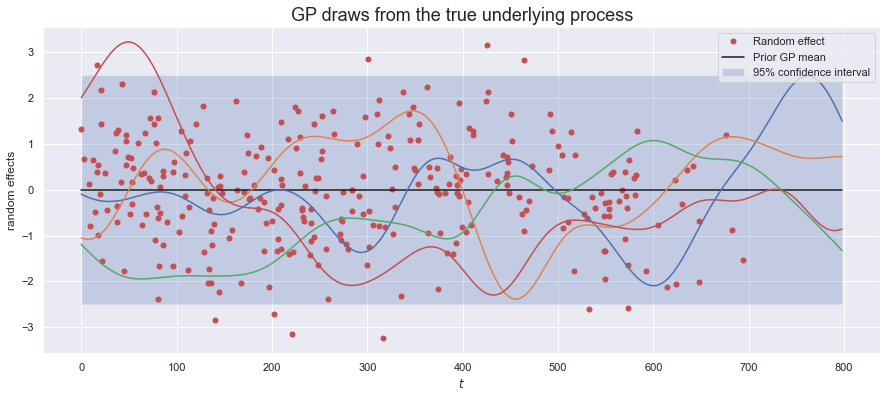

In [88]:
plt.figure(figsize=(15,6))
plt.plot(X_train['times'], y_train - F_train - 0.005 * X_train['times'], 'r.', markersize=10, label='Random effect') 
plt.fill_between(points, - 2.5 * np.ones_like(points),
                2.5 * np.ones_like(points), alpha=0.25,
                fc='b', label='95% confidence interval')
plt.plot(points, np.zeros_like(points), 'k', label='Prior GP mean')
for _ in range(4):
    rand_eff_realization = lambda t:  np.random.multivariate_normal(np.zeros_like(t) , exponential_kernel(t, t, rho=rho, sigma2=sigma_2))
    plt.plot(points, rand_eff_realization(points))
plt.title(f'GP draws from the true underlying process', fontsize=18)
plt.xlabel('$t$')
plt.ylabel('random effects')
plt.legend(loc='upper right');
plt.show()

## Predictions on the interapolation set

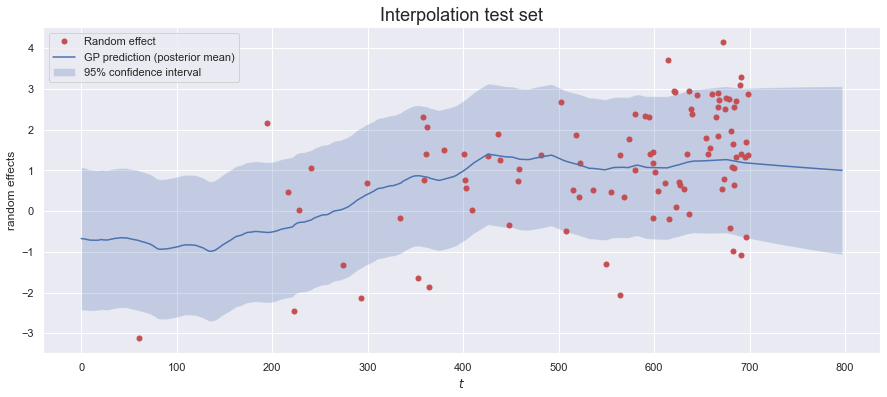

In [20]:
# Make predictions: latent variables and response variable
pred = bst.predict(data=X_test_int, gp_coords_pred=X_test_int['times'],  group_data_pred=X_test_int['group'],
                   predict_var=True, pred_latent=True)

# Make predictions using the fitted GP on the on the whole (0, 800) time interval
points = np.arange(X_test_int['times'].max() + 100, step=1)

predictions_points = gp_model.predict(gp_coords_pred=points, group_data_pred=np.zeros_like(points), predict_var=True)
sigma = np.sqrt(predictions_points['var'])


# Plot the results
plt.figure(figsize=(15,6))
plt.plot(X_test_int['times'], y_test_int - pred['fixed_effect'], 'r.', markersize=10, label='Random effect') 

#plt.plot(single_group_data['times'], predictions['random_effect_mean'], 'r.', markersize=10, label=f'Estimated random effects')
#plt.plot(single_group_data['times'].values, true_noisy_rand_effects, 'x', markersize=5, label='True noisy random effect') 
plt.plot(points, predictions_points['mu'], 'b-', label='GP prediction (posterior mean)')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                predictions_points['mu'] + 1.96 * sigma, alpha=0.25,
                fc='b', label='95% confidence interval')
plt.title(f'Interpolation test set', fontsize=18)
plt.xlabel('$t$')
plt.ylabel('random effects')
plt.legend(loc='upper left');
plt.show()

## Predictions on the extrapolation set

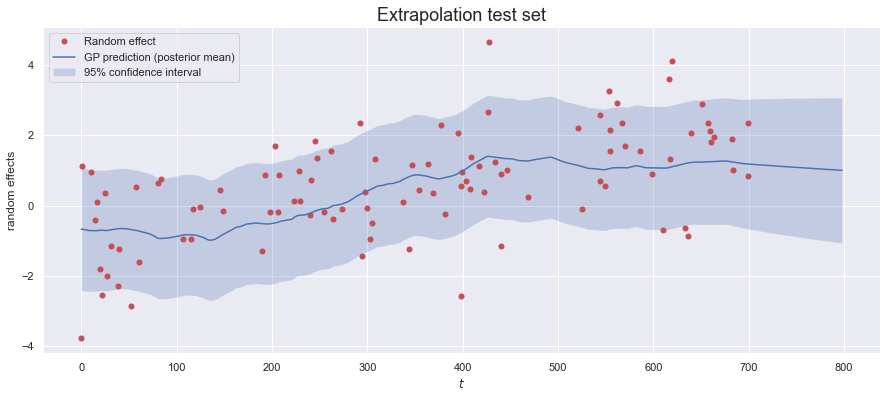

In [21]:
# Make predictions: latent variables and response variable
pred = bst.predict(data=X_test_ext, gp_coords_pred=X_test_ext['times'],  group_data_pred=X_test_ext['group'],
                   predict_var=True, pred_latent=True)

# Make predictions using the fitted GP on the on the whole (0, 800) time interval
points = np.arange(X_test_ext['times'].max() + 100, step=1)

predictions_points = gp_model.predict(gp_coords_pred=points, group_data_pred=np.zeros_like(points), predict_var=True)
sigma = np.sqrt(predictions_points['var'])


# Plot the results
plt.figure(figsize=(15,6))
plt.plot(X_test_ext['times'], y_test_ext - pred['fixed_effect'], 'r.', markersize=10, label='Random effect') 

#plt.plot(single_group_data['times'], predictions['random_effect_mean'], 'r.', markersize=10, label=f'Estimated random effects')
#plt.plot(single_group_data['times'].values, true_noisy_rand_effects, 'x', markersize=5, label='True noisy random effect') 
plt.plot(points, predictions_points['mu'], 'b-', label='GP prediction (posterior mean)')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                predictions_points['mu'] + 1.96 * sigma, alpha=0.25,
                fc='b', label='95% confidence interval')
plt.title(f'Extrapolation test set', fontsize=18)
plt.xlabel('$t$')
plt.ylabel('random effects')
plt.legend(loc='upper left');
plt.show()

# Fitting Gaussian Processes in Stan & analysing the hyperparameters posterior

In [9]:
gp_code = """
// Fit a Gaussian process's hyperparameters
// for squared exponential prior

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
transformed data {
  vector[N] mu;
  for (i in 1:N) 
    mu[i] <- 0;

}
parameters {
  // real<lower=0> eta_sq; // error term variance
  real<lower=4000> rho; // kernel lengthscale
  real<lower=0> sigma_sq; // kernel marginal variance
}
model {
  matrix[N, N] L_K;
  matrix[N,N] K;

  // off-diagonal elements
  for (i in 1:(N-1)) {
    for (j in (i+1):N) {
      K[i,j] <- sigma_sq * exp(- 1/rho * pow(x[i] - x[j],2));
      K[j,i] <- K[i,j];
    }
  }

  // diagonal elements
  for (k in 1:N)
    K[k,k] <- 0.25 + sigma_sq; // assume known error term variance is 0.25 (then K[k, k] = sigma_sq + error tern variance)
  
  L_K = cholesky_decompose(K);
  
    // Sigma[k,k] <- eta_sq + sigma_sq; // + jitter

  //eta_sq ~ std_normal();
  //rho ~ inv_gamma(5, 5);
  //rho ~ uniform(3000, 7000);
  rho ~ normal(5000, 1000);
  sigma_sq ~ std_normal();

  y ~ multi_normal_cholesky(mu, L_K); // this is faster
  //y ~ multi_normal(mu,Sigma);
}
"""

# Obtain the posterior of the kernel hyperparameters using MCMC 
RE_train = (y_train - F_train) - 0.005 * X_train['times']
gp_data = {'N': len(X_train), 'y': RE_train, 'x': X_train['times']}

gp_fit = pystan.stan(model_code=gp_code, data=gp_data,
                  iter=3000, chains=2, warmup=1000, n_jobs=-1, seed=1)

# Print a summary 
print(gp_fit.stansummary(pars=['rho', 'sigma_sq'], probs = (0.025, 0.975)))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a8206d74157cb8ff5810bf236eae48fa NOW.


Inference for Stan model: anon_model_a8206d74157cb8ff5810bf236eae48fa.
2 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
rho      4751.2   14.87 670.67 4013.7 6450.7   2035    1.0
sigma_sq   0.37  8.0e-3   0.29    0.1   1.18   1341    1.0

Samples were drawn using NUTS at Tue Jun 28 08:42:35 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


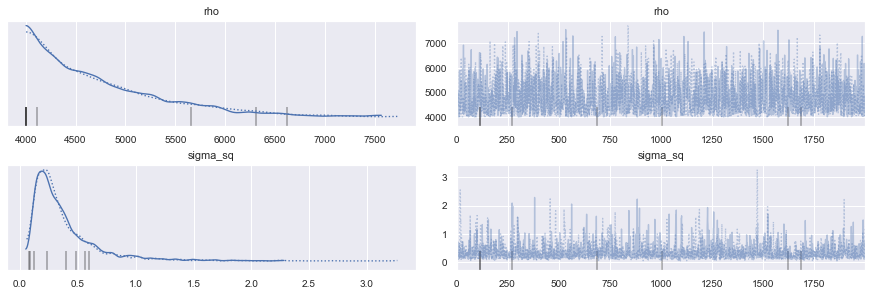

In [10]:
# Let's visualize the posteriors
ax = az.plot_trace(gp_fit, var_names = ["rho", "sigma_sq"])

We can see that the posterior distribution learnt for $\rho$ is far more accurate compared to the parameter value learnt by the GPBoost algorithm. 

INFO:numba.core.transforms:finding looplift candidates


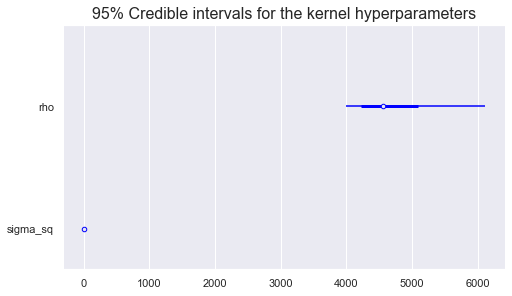

In [12]:
# Plot displaying only the 95% credible intervals
posterior_data = az.convert_to_dataset(gp_fit) 
axes = az.plot_forest(
    posterior_data,
    kind = "forestplot",
    hdi_prob = 0.95,
    var_names= ['rho', 'sigma_sq'],
    combined = True,
    ridgeplot_overlap = 1.5,
    colors = "blue",
    figsize = (7, 4),
)
axes[0].set_title('95% Credible intervals for the kernel hyperparameters' , fontsize=16);

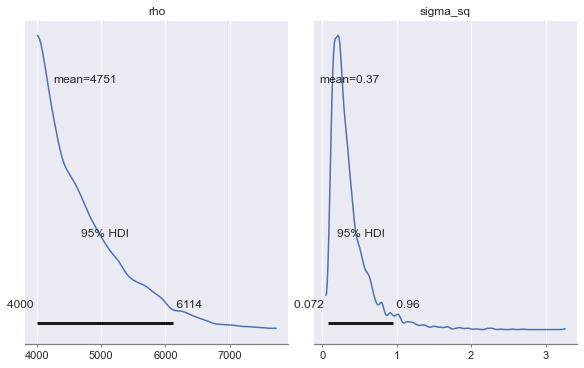

In [13]:
az.plot_posterior(data = posterior_data , var_names = ['rho', 'sigma_sq'], figsize=(8,5), point_estimate='mean',
                  hdi_prob=0.95);

## Let's see how the model would perform on the interpolation set random effects prediction task if we were to use the posterior means of the kernel hyperparameters we found above

### Interpolation set

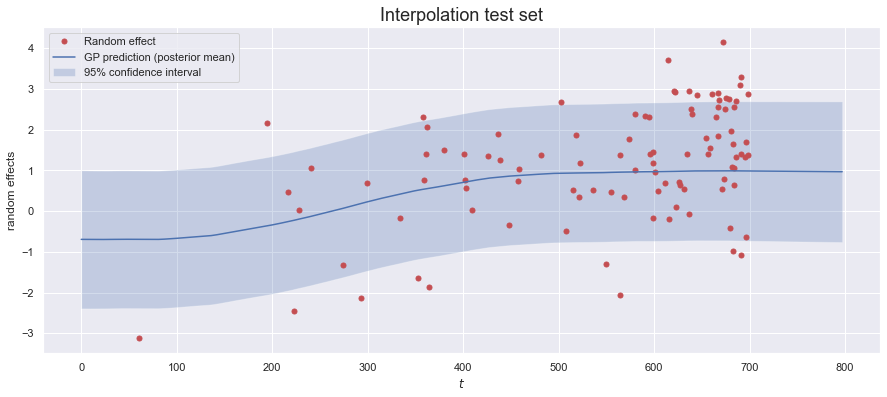

In [25]:
stan_params = np.array([0.68, 0.10, 0.37, 4751]) # [error term variance, group, kernel variance, kernel lengthscale]

# Make predictions: latent variables and response variable
pred = bst.predict(data=X_test_int, gp_coords_pred=X_test_int['times'],  group_data_pred=X_test_int['group'],
                   predict_var=True, pred_latent=True)

# Make predictions using the fitted GP on the on the whole (0, 800) time interval
points = np.arange(X_test_int['times'].max() + 100, step=1)

predictions_points = gp_model.predict(gp_coords_pred=points, predict_var=True, group_data_pred=np.zeros_like(points), cov_pars=stan_params)
sigma = np.sqrt(predictions_points['var'])


# Plot the results
plt.figure(figsize=(15,6))
plt.plot(X_test_int['times'], y_test_int - pred['fixed_effect'], 'r.', markersize=10, label='Random effect') 

#plt.plot(single_group_data['times'], predictions['random_effect_mean'], 'r.', markersize=10, label=f'Estimated random effects')
#plt.plot(single_group_data['times'].values, true_noisy_rand_effects, 'x', markersize=5, label='True noisy random effect') 
plt.plot(points, predictions_points['mu'], 'b-', label='GP prediction (posterior mean)')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                predictions_points['mu'] + 1.96 * sigma, alpha=0.25,
                fc='b', label='95% confidence interval')
plt.title(f'Interpolation test set', fontsize=18)
plt.xlabel('$t$')
plt.ylabel('random effects')
plt.legend(loc='upper left');
plt.show()

### Extrapolation set

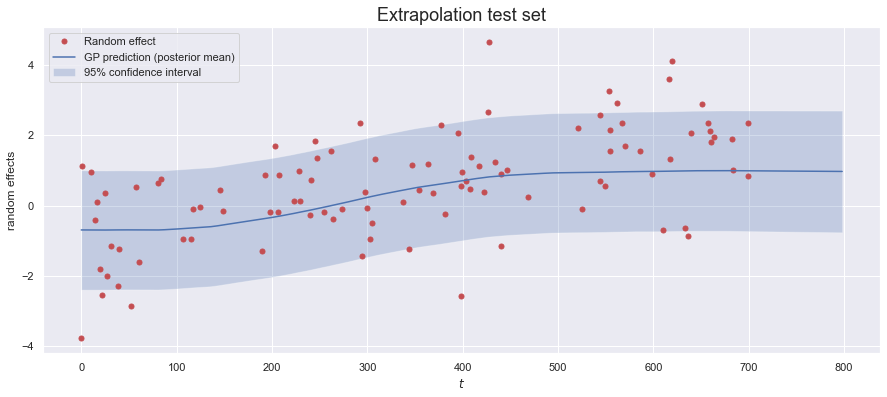

In [27]:
# Make predictions: latent variables and response variable
pred = bst.predict(data=X_test_ext, gp_coords_pred=X_test_ext['times'],  group_data_pred=X_test_ext['group'],
                   predict_var=True, pred_latent=True)

# Make predictions using the fitted GP on the on the whole (0, 800) time interval
points = np.arange(X_test_ext['times'].max() + 100, step=1)

predictions_points = gp_model.predict(gp_coords_pred=points, predict_var=True, group_data_pred=np.zeros_like(points), cov_pars=stan_params)
sigma = np.sqrt(predictions_points['var'])


# Plot the results
plt.figure(figsize=(15,6))
plt.plot(X_test_ext['times'], y_test_ext - pred['fixed_effect'], 'r.', markersize=10, label='Random effect') 

#plt.plot(single_group_data['times'], predictions['random_effect_mean'], 'r.', markersize=10, label=f'Estimated random effects')
#plt.plot(single_group_data['times'].values, true_noisy_rand_effects, 'x', markersize=5, label='True noisy random effect') 
plt.plot(points, predictions_points['mu'], 'b-', label='GP prediction (posterior mean)')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                predictions_points['mu'] + 1.96 * sigma, alpha=0.25,
                fc='b', label='95% confidence interval')
plt.title(f'Extrapolation test set', fontsize=18)
plt.xlabel('$t$')
plt.ylabel('random effects')
plt.legend(loc='upper left');
plt.show()

## Analysing the GPs of individual groups for a data-generating process with $\rho = 5000$ and $\sigma^2 = 1$

### GPBoost with individual GPs for each group

First train the model using the tuned hyperparameters obtained in cross-validation. 

In [6]:
gp_model = gpb.GPModel(group_data=X_train['group'], gp_coords=X_train['times'], cluster_ids=X_train['group'])
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})
params = {'objective': 'regression_l2',
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_data_in_leaf': 1,
          'verbose': 0}


train_data = gpb.Dataset(X_train.drop(columns=['group', 'times']), y_train)
start_time = time.time()
bst = gpb.train(params=params,
                train_set=train_data,
                gp_model=gp_model,
                num_boost_round=38)

gp_model.get_cov_pars()

,Error_term,group,GP_var,GP_range
Param.,0.0004,0.000003,1.560244,162.201841


Picking data points from group 3, we should note that all datapoints from that group apart from the last observation where in the train set. As a result, we can see below that the individual GP learned for group 3 matches correctly the all points seen in the training set but is not as accurate on the last point which is part of the test set.

Note: The specifics of the GPBoost model ensure that for data points seen during training time, y_true = predicted fixed effect + predicted random effect.

In [14]:
def plot_indGP_predictions(bst, gp_model, group_no, custom_GP_pred=False, posterior_params=None):

    if custom_GP_pred:
        assert posterior_params is not None , 'posterior_params must be provided'
    
    n_training_pts = len(X_train[X_train['group'] == group_no])
    single_group_data = full_data[full_data['group'] == group_no]
    y_true = single_group_data['y'].to_numpy()
    true_fixed_effects = F[full_data[full_data['group'] == group_no].index.values]
    true_noisy_rand_effects = y_true - true_fixed_effects

    # Predict using the fitted GPBoost model 
    predictions = bst.predict(data=single_group_data.drop(columns=['y', 'group', 'times']), 
                            group_data_pred=single_group_data['group'],
                            gp_coords_pred=single_group_data['times'],
                            cluster_ids_pred=single_group_data['group'],
                            predict_var=True, pred_latent=True)

    if custom_GP_pred: # Use the learned posterior parameters values
        print(gp_model.get_cov_pars().values.squeeze())
        new_GP_params = np.concatenate([gp_model.get_cov_pars().values.squeeze()[:2] , posterior_params])

    # Make predictions using the fitted GP on the on the whole (0, 800) time interval
    points = np.arange(single_group_data['times'].iloc[-1]+100, step=1)
    p = np.tile(single_group_data['group'].iloc[0], len(points))
    if custom_GP_pred:
        predictions_points = gp_model.predict(group_data_pred=p, gp_coords_pred=points, cluster_ids_pred=p, predict_var=True, cov_pars=new_GP_params)
    else:
        predictions_points = gp_model.predict(group_data_pred=p, gp_coords_pred=points, cluster_ids_pred=p, predict_var=True)
    sigma = np.sqrt(predictions_points['var'])


    # Plot the results
    plt.figure(figsize=(15,6))
    # Plot points in the training set
    plt.plot(single_group_data['times'][ : n_training_pts], y_true[ : n_training_pts] - predictions['fixed_effect'][ : n_training_pts], 'r.', markersize=10, label='Random effect training points') 
    plt.plot(single_group_data['times'][n_training_pts : ], y_true[n_training_pts : ] - predictions['fixed_effect'][n_training_pts : ], 'k.', markersize=10, label='Random effect test points') 
    #plt.plot(single_group_data['times'], predictions['random_effect_mean'], 'r.', markersize=10, label=f'Estimated random effects')
    #plt.plot(single_group_data['times'].values, true_noisy_rand_effects, 'x', markersize=5, label='True noisy random effect') 
    plt.plot(points, predictions_points['mu'], 'b-', label='GP prediction (posterior mean)')
    plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                    predictions_points['mu'] + 1.96 * sigma, alpha=0.25,
                    fc='b', label='95% confidence interval')
    plt.title(f'Group {group_no} random effects', fontsize=18)
    plt.xlabel('$t$')
    plt.ylabel('random effects')
    plt.legend(loc='upper left');
    plt.show()

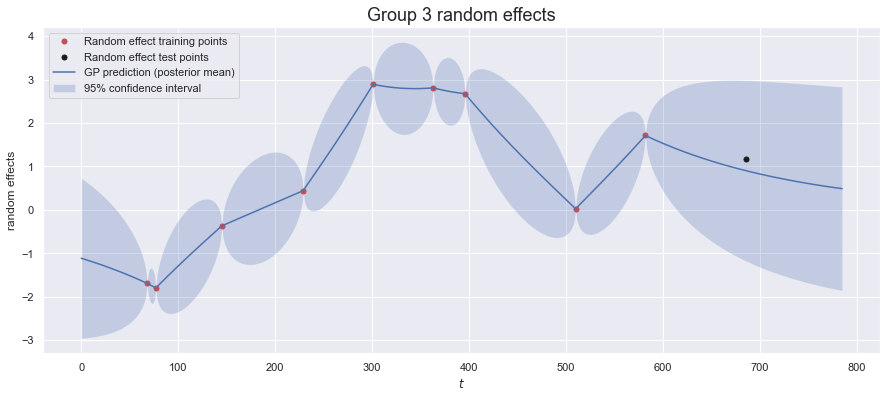

In [15]:
group_no = 3
single_group_data = full_data[full_data['group'] == group_no]
y_true = single_group_data['y'].to_numpy()
true_fixed_effects = F[full_data[full_data['group'] == group_no].index.values]
true_noisy_rand_effects = y_true - true_fixed_effects


plot_indGP_predictions(bst, gp_model, group_no=3)

Predictions on a group in the extrapolation set (i.e not seen in the training set) is simply 0 --> only predicting the fixed effects part. This is seen below for group 10:

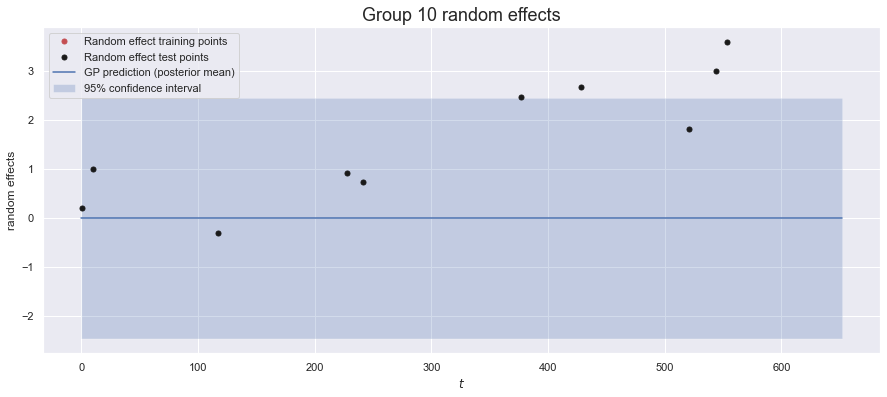

In [16]:
plot_indGP_predictions(bst, gp_model, group_no=10)

Let's also pick group 1, where 8 out of the 10 datapoints are in the (interpolation) test set. We can see that the resulting predictions are not very good. 

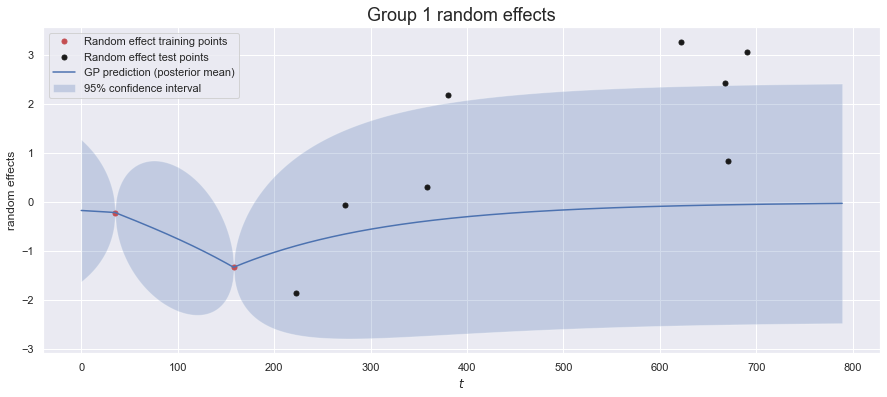

In [17]:
plot_indGP_predictions(bst, gp_model, group_no=1)

Final attempt on group 20 (5 points in training set and 5 in interpolation test set)

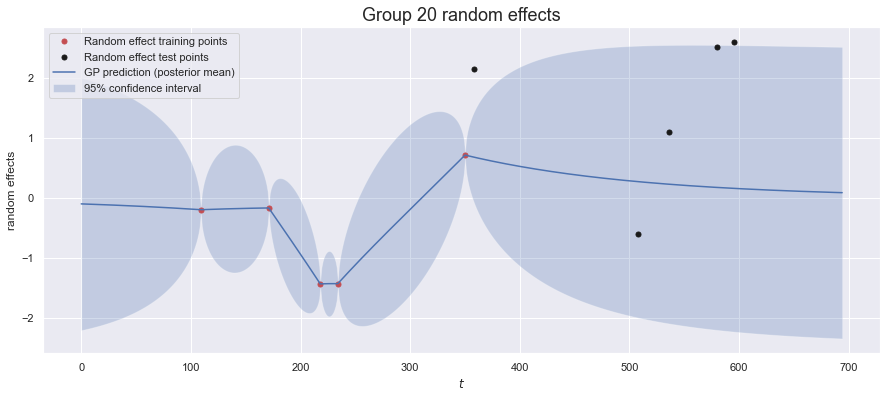

In [18]:
plot_indGP_predictions(bst, gp_model, group_no=20)

# Let's now attempt to learn the posterior distribution over $\rho$ and $\sigma^2$ using Stan and see if the random effects predictions look any different.

## Attempt on group 3

In [39]:
gp_code = """
// Fit a Gaussian process's hyperparameters
// for squared exponential prior

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
transformed data {
  vector[N] mu;
  for (i in 1:N) 
    mu[i] <- 0;

}
parameters {

  // real<lower=0> eta_sq; // error term variance 
  real<lower=0> rho; // kernel lengthscale
  real<lower=0> sigma_sq; // kernel marginal variance
  
}
model {
  matrix[N, N] L_K;
  matrix[N,N] K;

  // off-diagonal elements
  for (i in 1:(N-1)) {
    for (j in (i+1):N) {
      K[i,j] <- sigma_sq * exp(- 1/rho * pow(x[i] - x[j],2));
      K[j,i] <- K[i,j];
    }
  }

  // diagonal elements
  for (k in 1:N)
    K[k,k] <- 0.25 + sigma_sq; // assume known error term variance is 0.25 (then K[k, k] = sigma_sq + error tern variance)
  
  L_K = cholesky_decompose(K);
  
    // Sigma[k,k] <- eta_sq + sigma_sq; // + jitter

  //eta_sq ~ std_normal();
  //rho ~ inv_gamma(5, 5);
  //rho ~ uniform(3000, 7000);
  rho ~ normal(5000, 1000);
  sigma_sq ~ std_normal();

  y ~ multi_normal_cholesky(mu, L_K); // this is faster
  //y ~ multi_normal(mu,Sigma);
}
"""

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9043e183fb0ec8bc9d058e3eff36f636 NOW.


Inference for Stan model: anon_model_9043e183fb0ec8bc9d058e3eff36f636.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
rho      5234.3   29.85 980.73 3255.6 7120.6   1079    1.0
sigma_sq   1.22    0.01   0.47   0.51   2.35   1552    1.0

Samples were drawn using NUTS at Tue Jun 28 10:12:10 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


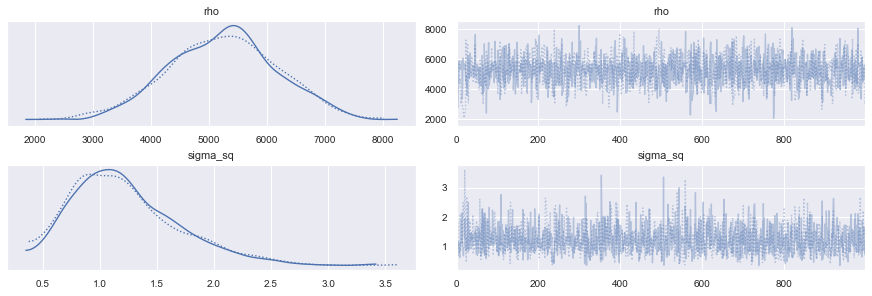

In [41]:
group_no , n_training_pts = 3 , 9


single_group_data = full_data[full_data['group'] == group_no]
y_true = single_group_data['y'].to_numpy()
true_fixed_effects = F[full_data[full_data['group'] == group_no].index.values]
true_noisy_rand_effects = y_true - true_fixed_effects - 0.005 * single_group_data['times'].values

# Obtain the posterior of the kernel hyperparameters using MCMC 
gp_data = {'N': len(single_group_data), 'y': true_noisy_rand_effects, 'x': single_group_data['times']}

gp_fit = pystan.stan(model_code=gp_code, data=gp_data,
                  iter=2000, chains=2, warmup=1000, n_jobs=-1, seed=1)

# Print a summary 
print(gp_fit.stansummary(pars=['rho', 'sigma_sq'], probs = (0.025, 0.975)))

# Let's visualize the posteriors
ax = az.plot_trace(gp_fit, var_names = ["rho", "sigma_sq"])

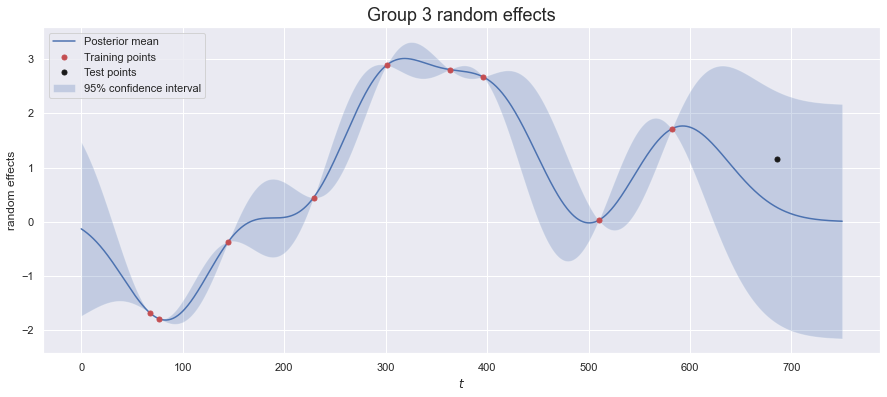

In [55]:
predictions = bst.predict(data=single_group_data.drop(columns=['y', 'group', 'times']), 
                            group_data_pred=single_group_data['group'],
                            gp_coords_pred=single_group_data['times'],
                            cluster_ids_pred=single_group_data['group'],
                            predict_var=True, pred_latent=True)

domain = np.linspace(0, 750, 1000)
# Condition on the first 6 datapoints which have been observed in the training set
x_obs = single_group_data['times'].values[:n_training_pts]
x_test = single_group_data['times'].values[n_training_pts:]

y_vals = single_group_data['y'].values - predictions['fixed_effect']
y_obs = y_vals[:n_training_pts]
y_test = y_vals[n_training_pts:]
#y_obs = true_noisy_rand_effects[:n_training_pts]
#y_test = true_noisy_rand_effects[n_training_pts:]

# Show the learned posterior over group 3 data
plt.figure(figsize=(15,6))
plot_conditional_functions(domain, get_exp_kernel(rho=5234, sigma2=1.22), x_obs, y_obs, sigma_n=0);
plt.plot(x_obs, y_obs, 'r.', markersize=10, label='Training points');
plt.plot(x_test, y_test, 'k.', markersize=10, label='Test points');

plt.title(f'Group {group_no} random effects', fontsize=18)
plt.xlabel('$t$')
plt.ylabel('random effects')
plt.legend(loc='upper left');
plt.show()

## We can see that the GP posterior learned is a lot closer to what we would expect it to look like given our true data-generating process.

## Attempt on group 1 (2 datapoints in training set and 8 in the interpolation test set)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9043e183fb0ec8bc9d058e3eff36f636 NOW.


Inference for Stan model: anon_model_9043e183fb0ec8bc9d058e3eff36f636.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
rho      5146.7   25.16 941.61 3278.5 6972.0   1401    1.0
sigma_sq   0.94    0.01   0.49   0.26   2.15   1615    1.0

Samples were drawn using NUTS at Tue Jun 28 11:01:51 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


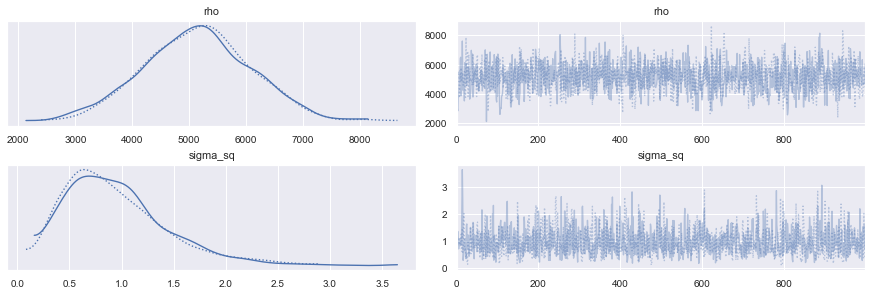

In [56]:
group_no , n_training_pts = 1 , 2


single_group_data = full_data[full_data['group'] == group_no]
y_true = single_group_data['y'].to_numpy()
true_fixed_effects = F[full_data[full_data['group'] == group_no].index.values]
true_noisy_rand_effects = y_true - true_fixed_effects - 0.005 * single_group_data['times'].values

# Obtain the posterior of the kernel hyperparameters using MCMC 
gp_data = {'N': len(single_group_data), 'y': true_noisy_rand_effects, 'x': single_group_data['times']}

gp_fit = pystan.stan(model_code=gp_code, data=gp_data,
                  iter=2000, chains=2, warmup=1000, n_jobs=-1, seed=1)

# Print a summary 
print(gp_fit.stansummary(pars=['rho', 'sigma_sq'], probs = (0.025, 0.975)))

# Let's visualize the posteriors
ax = az.plot_trace(gp_fit, var_names = ["rho", "sigma_sq"])

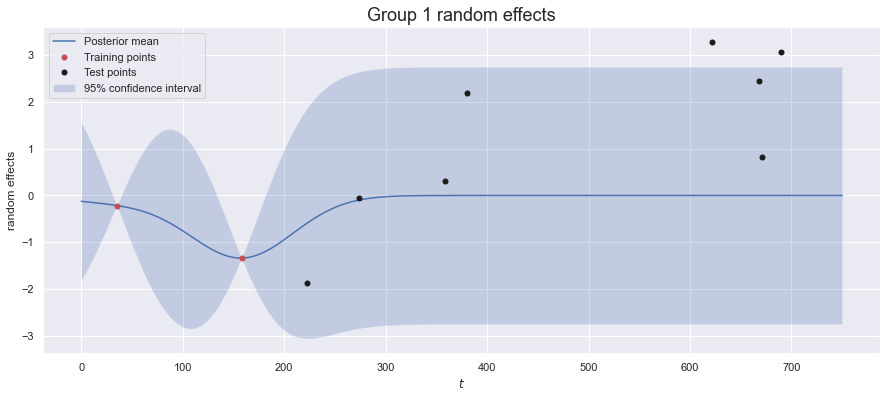

In [72]:
predictions = bst.predict(data=single_group_data.drop(columns=['y', 'group', 'times']), 
                            group_data_pred=single_group_data['group'],
                            gp_coords_pred=single_group_data['times'],
                            cluster_ids_pred=single_group_data['group'],
                            predict_var=True, pred_latent=True)

domain = np.linspace(0, 750, 1000)
# Condition on the first 6 datapoints which have been observed in the training set
x_obs = single_group_data['times'].values[:n_training_pts]
x_test = single_group_data['times'].values[n_training_pts:]

y_vals = single_group_data['y'].values - predictions['fixed_effect']
y_obs = y_vals[:n_training_pts]
y_test = y_vals[n_training_pts:]
#y_obs = true_noisy_rand_effects[:n_training_pts]
#y_test = true_noisy_rand_effects[n_training_pts:]

# Show the learned posterior over group 3 data
plt.figure(figsize=(15,6))
plot_conditional_functions(domain, get_exp_kernel(rho=5147, sigma2=1.96), x_obs, y_obs, sigma_n=0);
plt.plot(x_obs, y_obs, 'r.', markersize=10, label='Training points');
plt.plot(x_test, y_test, 'k.', markersize=10, label='Test points');

plt.title(f'Group {group_no} random effects', fontsize=18)
plt.xlabel('$t$')
plt.ylabel('random effects')
plt.legend(loc='upper left');
plt.show()

## Attempt on Group 20

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9043e183fb0ec8bc9d058e3eff36f636 NOW.


Inference for Stan model: anon_model_9043e183fb0ec8bc9d058e3eff36f636.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
rho      4841.3   25.77 959.25 2965.8 6682.1   1386    1.0
sigma_sq   0.92    0.01   0.46   0.26   2.04   1212    1.0

Samples were drawn using NUTS at Tue Jun 28 11:05:38 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


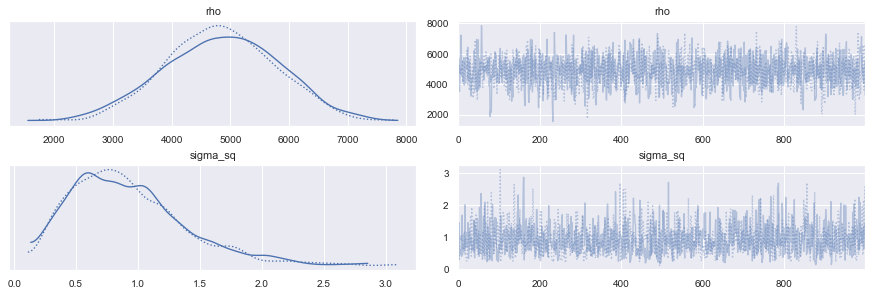

In [59]:
group_no , n_training_pts = 20 , 5


single_group_data = full_data[full_data['group'] == group_no]
y_true = single_group_data['y'].to_numpy()
true_fixed_effects = F[full_data[full_data['group'] == group_no].index.values]
true_noisy_rand_effects = y_true - true_fixed_effects - 0.005 * single_group_data['times'].values

# Obtain the posterior of the kernel hyperparameters using MCMC 
gp_data = {'N': len(single_group_data), 'y': true_noisy_rand_effects, 'x': single_group_data['times']}

gp_fit = pystan.stan(model_code=gp_code, data=gp_data,
                  iter=2000, chains=2, warmup=1000, n_jobs=-1, seed=1)

# Print a summary 
print(gp_fit.stansummary(pars=['rho', 'sigma_sq'], probs = (0.025, 0.975)))

# Let's visualize the posteriors
ax = az.plot_trace(gp_fit, var_names = ["rho", "sigma_sq"])

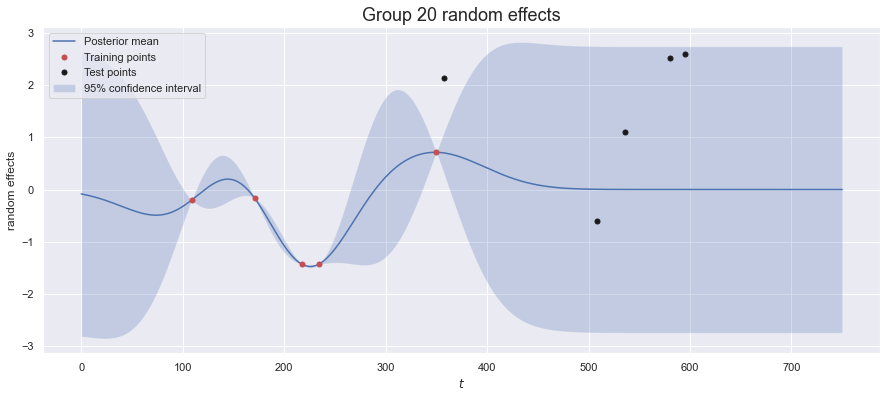

In [77]:
predictions = bst.predict(data=single_group_data.drop(columns=['y', 'group', 'times']), 
                            group_data_pred=single_group_data['group'],
                            gp_coords_pred=single_group_data['times'],
                            cluster_ids_pred=single_group_data['group'],
                            predict_var=True, pred_latent=True)

domain = np.linspace(0, 750, 1000)
# Condition on the first 6 datapoints which have been observed in the training set
x_obs = single_group_data['times'].values[:n_training_pts]
x_test = single_group_data['times'].values[n_training_pts:]

y_vals = single_group_data['y'].values - predictions['fixed_effect']
y_obs = y_vals[:n_training_pts]
y_test = y_vals[n_training_pts:]
#y_obs = true_noisy_rand_effects[:n_training_pts]
#y_test = true_noisy_rand_effects[n_training_pts:]

# Show the learned posterior over group 3 data
plt.figure(figsize=(15,6))
plot_conditional_functions(domain, get_exp_kernel(rho=4841, sigma2=1.96), x_obs, y_obs, sigma_n=0.0);
plt.plot(x_obs, y_obs, 'r.', markersize=10, label='Training points');
plt.plot(x_test, y_test, 'k.', markersize=10, label='Test points');

plt.title(f'Group {group_no} random effects', fontsize=18)
plt.xlabel('$t$')
plt.ylabel('random effects')
plt.legend(loc='upper left');
plt.show()

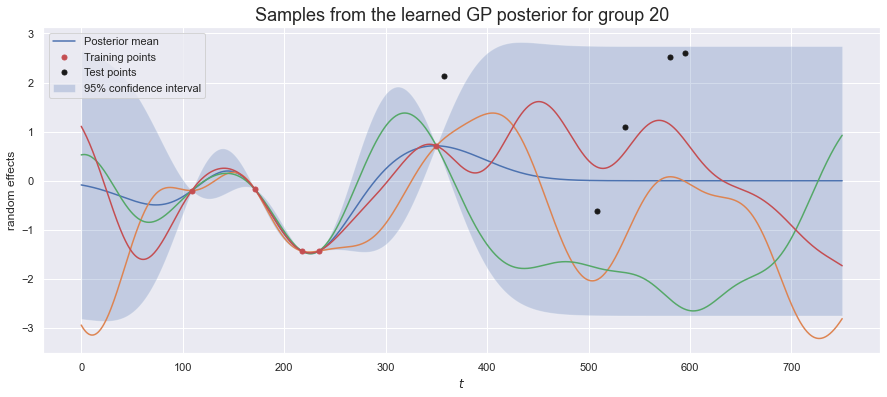

In [79]:
plt.figure(figsize=(15,6))
plot_conditional_functions(domain, get_exp_kernel(rho=4841, sigma2=1.96), x_obs, y_obs, sigma_n=0.0, posterior_samples=True, N_samples=3);
plt.plot(x_obs, y_obs, 'r.', markersize=10, label='Training points');
plt.plot(x_test, y_test, 'k.', markersize=10, label='Test points');

plt.title(f'Samples from the learned GP posterior for group {group_no}', fontsize=18)
plt.xlabel('$t$')
plt.ylabel('random effects')
plt.legend(loc='upper left');
plt.show()

## Testing the hypothesis of whether using the posterior mean of $\rho$ and $\sigma^2$ instead of the learned kernel hyperparameters in the GPBoost fitting improves prediction performance.

In [3]:
gp_code = """
// Fit a Gaussian process's hyperparameters
// for squared exponential prior

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
transformed data {
  vector[N] mu;
  for (i in 1:N) 
    mu[i] <- 0;

}
parameters {
  // real<lower=0> eta_sq; // error term variance
  real<lower=3000, upper=7000> rho; // kernel lengthscale
  real<lower=0> sigma_sq; // kernel marginal variance
}
model {
  matrix[N, N] L_K;
  matrix[N,N] K;

  // off-diagonal elements
  for (i in 1:(N-1)) {
    for (j in (i+1):N) {
      K[i,j] <- sigma_sq * exp(- 1/rho * pow(x[i] - x[j],2));
      K[j,i] <- K[i,j];
    }
  }

  // diagonal elements
  for (k in 1:N)
    K[k,k] <- 0.25 + sigma_sq; // assume known error term variance is 0.25 (then K[k, k] = sigma_sq + error tern variance)
  
  L_K = cholesky_decompose(K);
  
    // Sigma[k,k] <- eta_sq + sigma_sq; // + jitter

  //eta_sq ~ std_normal();
  //rho ~ inv_gamma(5, 5);
  rho ~ uniform(3000, 7000);
  sigma_sq ~ std_normal();

  y ~ multi_normal_cholesky(mu, L_K); // this is faster
  //y ~ multi_normal(mu,Sigma);
}
"""

In [2]:
# Generate data
n, m = 500, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
n_datasets = 20 
n_valid = 5

########################
rho , sigma_2 = 5000 , 1
########################

datasets, validation_datasets = generate_datasets(n, m, p, n_datasets, n_valid, func='make_friedman3', random_state=60, shared_gp=True, rho=rho, sigma2_2=sigma_2)

# Create groups
groups = np.arange(n)
for i in range(m):
    groups[i*p:(i+1)*p] = i

# Create times for validation datasets
times = np.tile(np.arange(p)*10+10, m)

X_train = datasets['X_train'][0]
F_train = datasets['F_train'][0]
y_train = datasets['y_train'][0]
X_test_int = datasets['X_test2'][0]
X_test_ext = datasets['X_test1'][0]
y_test_int = datasets['y_test2'][0]
y_test_ext = datasets['y_test1'][0]
F_test_int = datasets['F_test2'][0]
F_test_ext = datasets['F_test1'][0]
full_data = datasets['data'][0]
full_data.head()

,group,times,feature_1,feature_2,feature_3,feature_4,y
0,0,18,30.087333,431.063660,0.323183,7.657496,2.048196
1,0,38,56.697080,776.262596,0.379415,1.105815,2.859202
2,0,120,17.036560,327.242594,0.692401,9.744416,5.385089
3,0,224,33.739690,1746.973065,0.131540,6.003298,6.068965
4,0,272,28.662051,486.017341,0.502086,7.360625,3.949509


In [4]:
# 7. GPBoost with Shared Gaussian Process
params = {'learning_rate': 0.1,
          'max_depth': 3,
          'min_data_in_leaf': 1,
          'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}
          
#stan_params = np.array([0.716, 0.987857, 2.3, 3554]) # [error term variance, group, kernel variance, kernel lengthscale]
#true_params = np.array([0.25, 1, 1, 5000])
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test_customGP(datasets, n_datasets, num_boost_round=41, params=params, linear=False, kernel='exponential', custom_cov_pars=None, stan_GP_code=gp_code, no_chains=1)  
#time_list, RMSE_list1, RMSE_list2, F_list = train_and_test_customGP(datasets, n_datasets, num_boost_round=57, params=params, linear=False, kernel='exponential', custom_cov_pars=cov_params)  
print(np.mean(RMSE_list1), np.mean(RMSE_list2), np.mean(F_list), np.mean(time_list))
print(np.std(RMSE_list1), np.std(RMSE_list2), np.std(F_list))

  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e72634078474f1b78be809ea5f5a9c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e72634078474f1b78be809ea5f5a9c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e72634078474f1b78be809ea5f5a9c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e72634078474f1b78be809ea5f5a9c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e72634078474f1b78be809ea5f5a9c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e72634078474f1b78be809ea5f5a9c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e72634078474f1b78be809ea5f5a9c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e72634078474f1b78be809ea5f5a9c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e72634078474f1b78be809ea5f5a9c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e72634078474f1b78be809ea5f5a9c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66e7

1.5895639353002204 1.3208744920551512 1.5368865108631715 1.5832844853401185
0.2020985053361626 0.12795964613181499 0.1764647993987125


In [5]:
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=41, params=params, merf=False, 
                                                            linear=False, GP=True, shared=True, kernel='exponential') 
print(np.mean(RMSE_list1), np.mean(RMSE_list2), np.mean(F_list), np.mean(time_list))
print(np.std(RMSE_list1), np.std(RMSE_list2), np.std(F_list))

  0%|          | 0/20 [00:00<?, ?it/s]

1.5962093081247297 1.322413445887402 1.5368865108631715 1.9592599868774414
0.20310503687335402 0.12714070951981823 0.1764647993987125


We can see that in both cases, the learned parameters from the posterior result in more accurate predictions, even if these differences are not very significant. 